# Load data

In [1]:
import h5py

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
gslib = h5py.File("gslib", "r")

In [3]:
tcga_mgi_gslib = gslib['TCGA-MGI']

In [4]:
rna_level_predictions = h5py.File("rna_level_predictions.hdf5", "r")
rna_data = rna_level_predictions['data']
rna_meta = rna_level_predictions['meta']

In [5]:
go_bp_gslib = rna_data['go_bp_gslib']
kegg_gslib = rna_data['kegg_human_gslib']
mgi_gslib = rna_data['mgi_gslib']

In [6]:
go_bp_genes = [ str(go[0])[2:-1] for go in rna_meta['go_bp_genes'] ]
go_bp_pheno = [ str(gp[0])[2:-1] for gp in rna_meta['go_bp_phenotypes'] ]
kegg_human_genes = [ str(k[0])[2:-1] for k in rna_meta['kegg_human_genes'] ]
kegg_human_pheno = [ str(kp[0])[2:-1] for kp in rna_meta['kegg_human_phenotypes'] ] 
mgi_genes = [ str(m[0])[2:-1] for m in rna_meta['mgi_genes'] ]
mgi_pheno = [ str(mp[0])[2:-1] for mp in rna_meta['mgi_phenotypes'] ]
tcga_genes = [ str(g[0])[2:-1] for g in rna_meta['tcga_genes'] ]

In [7]:
two_gslibs = h5py.File("two_gslibs.hdf5", "r")

In [8]:
tcga_go_bp_gslib = two_gslibs['tcga_GO_BP']
tcga_kegg_gslib = two_gslibs['tcga_kegg_human_tcga']

In [9]:
mgi = h5py.File("mpi.hdf5", "r")

# Get binary matrices

In [18]:
from tqdm import trange
import numpy as np
import pandas as pd

In [19]:
file_name = "MGI_Mammalian_Phenotype_Level_4_2019.txt"

In [20]:
d = {} 
with open(file_name) as file:
    for line in file:
        lst = line.strip().split("\t")
        ph = lst[0]
        lst = lst[2:]
        d[ph] = lst

In [21]:
gene_dict = {}
for k,v in d.items(): 
    for gene in v: 
        if gene not in gene_dict: 
            gene_dict[gene] = []
        gene_dict[gene].append(k)

In [22]:
functions = list(d.keys())
gslib_genes = list(gene_dict.keys())
gene_set = np.zeros((len(gslib_genes), len(functions)))

In [23]:
for row in trange(len(gene_set)): 
    gene = gslib_genes[row] 
    for col in range(len(functions)):
        f = functions[col]
        if f in gene_dict[gene]: 
            gene_set[row][col] = 1

100%|██████████| 13420/13420 [00:47<00:00, 283.95it/s]


In [24]:
binary_matrix = gene_set

# Gather variables

In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import norm
from matplotlib import pyplot

In [26]:
common_genes = list(set(tcga_genes) & set(mgi_genes))

In [27]:
mgi_gslib = pd.DataFrame(mgi_gslib)

In [28]:
len(common_genes)
gene1 = common_genes[-1]

In [29]:
tcga_idx = np.where(np.transpose(tcga_genes) == gene1)[0][0]
mgi_idx = np.where(np.transpose(mgi_genes) == gene1)[0][0]
row1 = mgi_gslib.loc[mgi_idx]

In [30]:
y_true = binary_matrix[mgi_idx]

In [31]:
y_probs = tcga_mgi_gslib[tcga_idx]

In [32]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

In [33]:
# calculate AUC
auc = roc_auc_score(y_true, y_probs)
print('AUC: %.3f' % auc)

AUC: 0.699


In [39]:
auc_list = []
for g in common_genes: 
    tcga_idx = np.where(np.transpose(tcga_genes) == g)[0][0]
    mgi_idx = np.where(np.transpose(mgi_genes) == g)[0][0]
    row1 = mgi_gslib.loc[mgi_idx]
    y_true = binary_matrix[mgi_idx]
    y_probs = row1
#     y_probs = tcga_mgi_gslib[tcga_idx]
    # calculate AUC
    auc = roc_auc_score(y_true, y_probs)
    auc_list.append(auc)

In [40]:
np.mean(auc_list)

0.5762377049896732

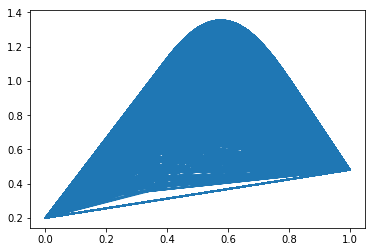

In [46]:
m = np.mean(auc_list)
sd = np.std(auc_list)
pdf = norm.pdf(auc_list, m, sd)
pyplot.plot(auc_list, pdf)
pyplot.show()